# Linear regression example

This tutorial demonstrates the application of linear regression to test for QTL associations.

In [4]:
#set up plotting ebvironment
%matplotlib inline
from setup import *

First we load the yeast cross dataset.

In [5]:
#import data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
file_name = tutorial_data.get_file('BYxRM')
geno_reader  = gr.genotype_reader_tables(file_name)
pheno_reader = phr.pheno_reader_tables(file_name)

#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)

In [6]:
#the data object allows to query specific genotype or phenotype data
dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)
#getting genotypes
snps = dataset.getGenotypes() #SNPs
position = dataset.getPos()
position['chrom']
position,chromBounds = data_util.estCumPos(position=position,offset=0)

#phenotype
P_max = 3
phenotype_ID = dataset.phenotype_ID[0:P_max]
phenotype_vals, sample_idx = dataset.getPhenotypes(phenotype_ID)

N = snps.shape[0] #number of individuals
S = snps.shape[1] #number of SNPs
P = phenotype_vals.shape[1]#number of phenotypes


## Normal distributed phenotypes and phenotype transformations

To explore the phenotypic data, we create a histogram of the phenotype values.

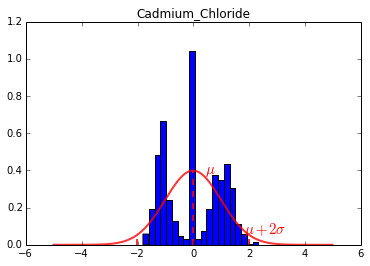

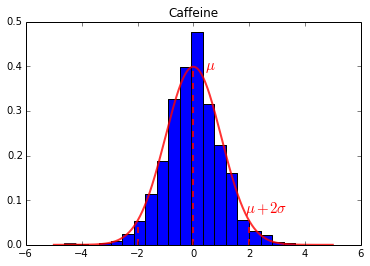

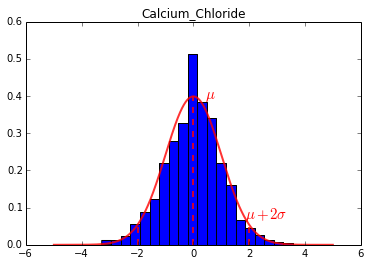

In [7]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[3,3])#create the figure
    
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals.values[:,ip],alpha=0.8)
    pl.title("%s" % p_ID)

Some of the phenotypes deviate from a normal distribution.
One of the assumptions of the linear regression model we use for association testing is that the model residuals are normal distrbuted.
Violation of this assumption leads to biases in the analysis.
We only have access to the residuals after fitting the model.
Under the assumption that the model eplains only a small portion of phenotypic variation we can assess the phenotype values instead.

### Transforming phenotypes

To make the data look more normal distrbuted, we apply two different phenotype transformations, the Box-Cox transformation and a non-parametric rank-based transformation.

#### Box-Cox transformation

The Box-Cox transformation makes the data "more normal" by fitting a power transformation with one parameter to the observed phenotypic data.

In [8]:
phenotype_vals_boxcox, maxlog = preprocess.boxcox(phenotype_vals.values)

#### Rank-based (non-parametric) transformation

The rank-based transformation makes the data look absolutely normal by converting the data first to ranks and then transforming it to the corresponding quantiles of a normal distribution. As this transformatino does not have a parameter (or actually one parameter per sample, namely the normal quantile), it is called non-paramteric.

In [9]:
phenotype_vals_ranks = preprocess.rankStandardizeNormal(phenotype_vals.values)

Let's look at the histograms after transformation:

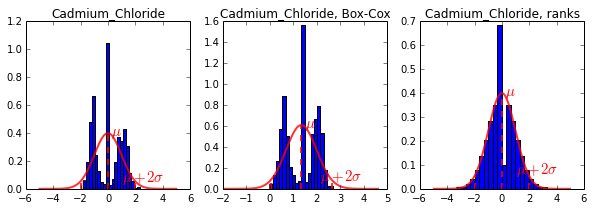

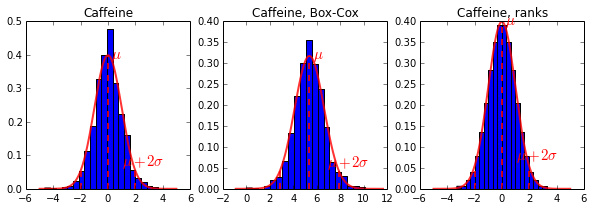

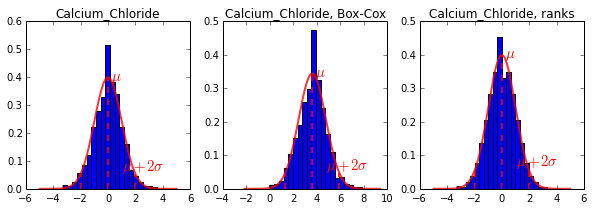

In [10]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,3,1)#the untransformed phenotypes
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals.values[:,ip],alpha=0.8,figure=plt)
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,3,2)#the untransformed phenotypes
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals_boxcox[:,ip],alpha=0.8,figure=plt)
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)#the rank transformed phenotypes
    #histogram of the untransformed phenotypes
    plot_normal(phenotype_vals_ranks[:,ip],alpha=0.8,figure=plt)
    pl.title("%s, ranks" % p_ID)

### GWAS testing using linear regression on the original phenotype:

In [11]:
#run linear regression on each SNP
lm = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals.values)

#convert P-values to a DataFrame for nice output writing:
pvalues_lm = pd.DataFrame(data=lm.pvalues.T,index=dataset.geno_ID,
                       columns=phenotype_ID)

A common way to visualize the results of a GWAS is a Manhatten plot, where the $-log_{10}$ P-values are plotted against the genomic position.

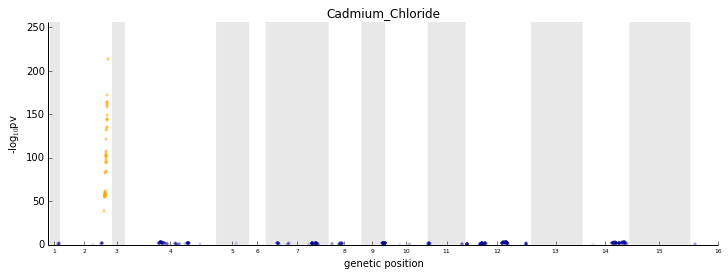

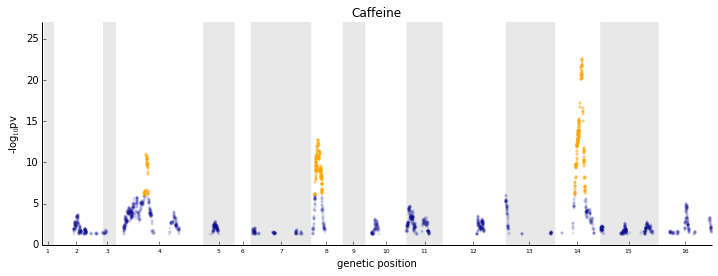

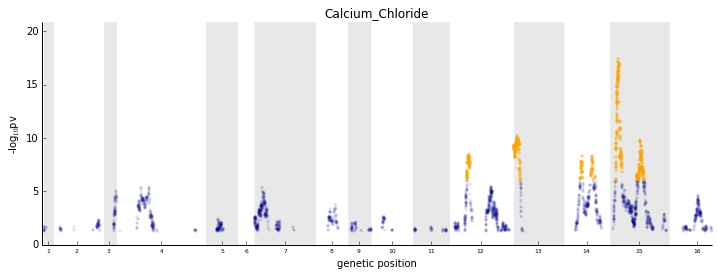

In [12]:
# Genome-wide manhatton plots for one phenotype:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[12,4])
    plot_manhattan(posCum=position['pos_cum'],pv=pvalues_lm[p_ID].values,chromBounds=chromBounds,thr_plotting=0.05)
    pl.title(p_ID)

### Observations:

* Several peaks are visible.

* The peaks entail multiple neighboring SNPs due to linkage disequilibrium to the causal variant.

##### GWAS testing using linear regression on the transformed phenotypes:

First we analyze the Box-Cox transformed phenotypes.

In [13]:
#run linear regression on each SNP
lm_boxcox = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals_boxcox)

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_boxcox = pd.DataFrame(data=lm_boxcox.pvalues.T,index=dataset.geno_ID,
                       columns=phenotype_ID)

Next, we analyze the phenotypes transformed by the rank-based transformation.

In [14]:
#run linear regression on each SNP
lm_ranks = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals_ranks)

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_ranks = pd.DataFrame(data=lm_ranks.pvalues.T,index=dataset.geno_ID,
                       columns=phenotype_ID)

To compare the results on the various transformations and the orignial data, we create correlation plots between the P-values.

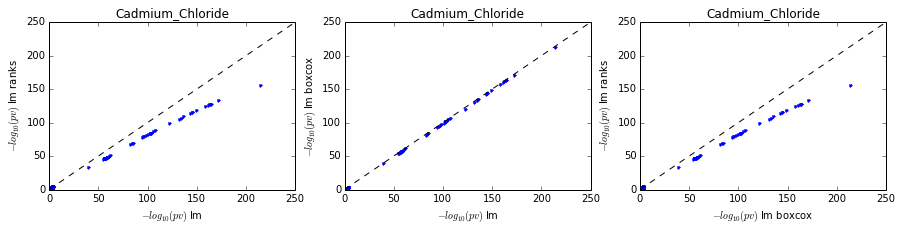

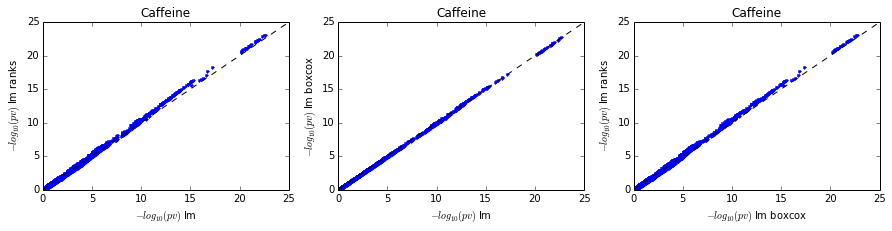

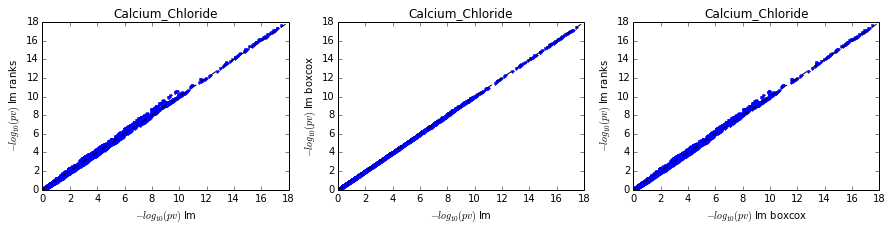

In [15]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[15,3])#create the figure
    pl.subplot(1,3,1)
    pl.plot(-sp.log10(pvalues_lm[p_ID].values),-sp.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.subplot(1,3,2)
    pl.plot(-sp.log10(pvalues_lm[p_ID].values),-sp.log10(pvalues_lm_boxcox[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm')
    pl.ylabel('$-log_{10}(pv)$ lm boxcox')
    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    pl.title(p_ID)
    pl.subplot(1,3,3)
    pl.plot(-sp.log10(pvalues_lm_boxcox[p_ID].values),-sp.log10(pvalues_lm_ranks[p_ID].values),'.')
    pl.xlabel('$-log_{10}(pv)$ lm boxcox')
    pl.ylabel('$-log_{10}(pv)$ lm ranks')
    pl.title(p_ID)

    max_range = max(pl.xlim()[1],pl.ylim()[1])
    pl.plot([0,max_range],[0,max_range],'k--')
    


Next, we look at the residuals at the strongest associated SNP by plotting the phenotype values against the SNP.

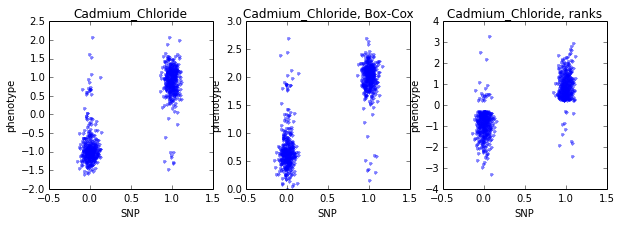

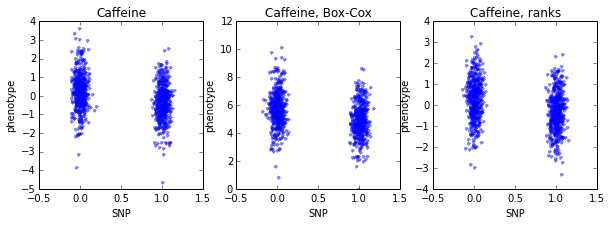

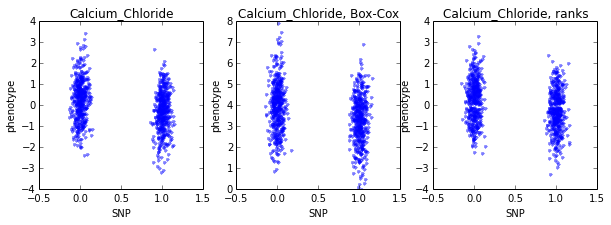

In [16]:

for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])#create the figure
    
    plt = pl.subplot(1,3,1)#the untransformed phenotypes
    #find maximum squared beta value
    pheno_vals, s_idx = dataset.getPhenotypes([p_ID])
    
    imax = lm.pvalues[ip].argmin()
    i_0 = snps[s_idx,imax]==0

    #plot SNP vs. phenotype for max beta
    
    pl.plot(snps[s_idx,imax]+0.05*np.random.randn(snps[s_idx,imax].shape[0]),pheno_vals.values,'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s" % p_ID)

    plt = pl.subplot(1,3,2)#the Box-Cox transformed phenotypes
    pl.plot(snps[s_idx,imax]+0.05*np.random.randn(snps[s_idx,imax].shape[0]),phenotype_vals_boxcox[s_idx[sample_idx],ip],'.',alpha=0.5)
    
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)#the rank transformed phenotypes
    pl.plot(snps[s_idx,imax]+0.05*np.random.randn(snps[s_idx,imax].shape[0]),phenotype_vals_ranks[s_idx[sample_idx],ip],'.',alpha=0.5)
    
    #pl.plot([0,1],[pheno_vals.values[i_0].mean(),pheno_vals.values[~i_0].mean()])
    pl.xlabel("SNP")
    pl.ylabel("phenotype")
    pl.xlim([-0.5,1.5])
    pl.title("%s, ranks" % p_ID)
    

There is an interesting artifact visible from the rank-transformation. On the original data there are two peaks visible. By making the data look normal distributed, the two peaks are merged together. Once conditioning on the strongest SNP, which seems to have a Mendelian effect on the phenotype, the residuals become less normal distributed than for the original data.

## Assessing the P-value distribution

For SNPs that are truely not associated with the phenotype (the null hypotheses), P-values should be uniformly distributed between 0 and 1.
As in GWAS we test a large number of SNPs, most of which are probably not associated, we should largely get normal distributed P-values.

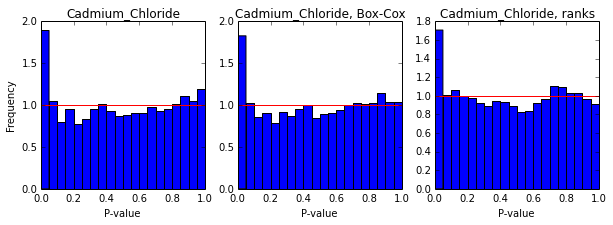

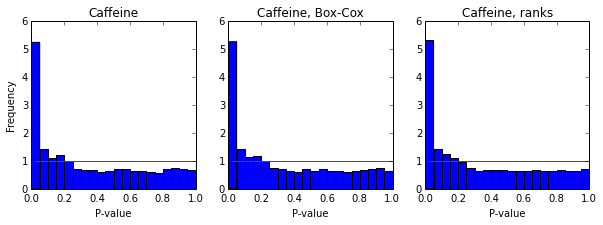

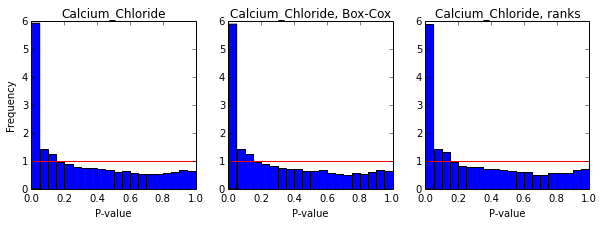

In [17]:
# P-value histgrams

for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    pl.hist(pvalues_lm[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s" % p_ID)
    pl.xlabel("P-value")
    pl.ylabel("Frequency")
    
    plt = pl.subplot(1,3,2)
    pl.hist(pvalues_lm_boxcox[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, Box-Cox" % p_ID)
    pl.xlabel("P-value")
    
    plt = pl.subplot(1,3,3)
    pl.hist(pvalues_lm_ranks[p_ID].values,20,normed=True)
    pl.plot([0,1],[1,1],"r")
    pl.title("%s, ranks" % p_ID)
    pl.xlabel("P-value")
    
    

From the histogram of P-values we observe that there are a large number of uniformly distributed P-values, but also a portion of small P-values.

#### P-value Quantile-Quantile plots

The difference of the observed P-value distrbution and the distributions lies mostly in the range of small P-values. By comparing the quantiles of the negative log P-values to the negative log uniform quantiles, this difference betcomes even more visible.

Question:

* How can non-uniform p-values be explained in this dataset? 

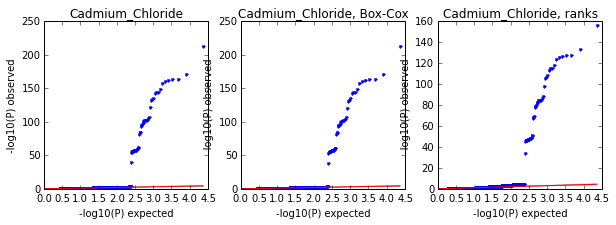

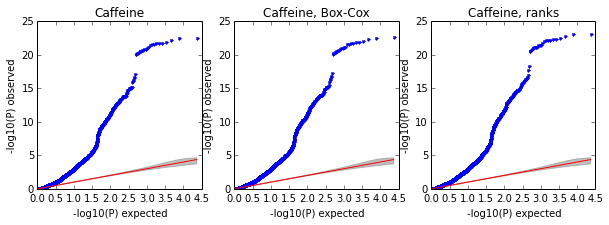

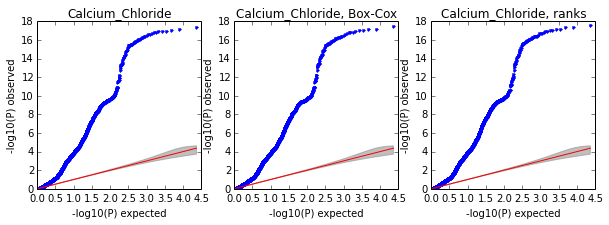

In [18]:
# Quantile-Quantile plots

for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[10,3])
    
    plt = pl.subplot(1,3,1)
    qqplot(pvalues_lm[p_ID].values)
    pl.title("%s" % p_ID)
    
    plt = pl.subplot(1,3,2)
    qqplot(pvalues_lm_boxcox[p_ID].values)
    pl.title("%s, Box-Cox" % p_ID)
    
    plt = pl.subplot(1,3,3)
    qqplot(pvalues_lm_ranks[p_ID].values)
    pl.title("%s, ranks" % p_ID)
    

The grey area in the plots marks the $\alpha=0.01$ confidence interval for the hypothesis that all or P-values come from the null distribution (are uniform) 

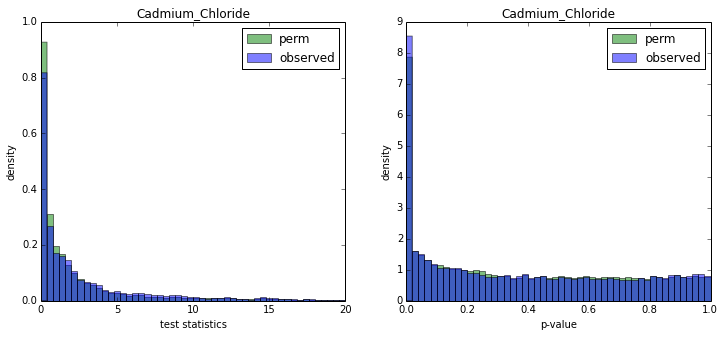

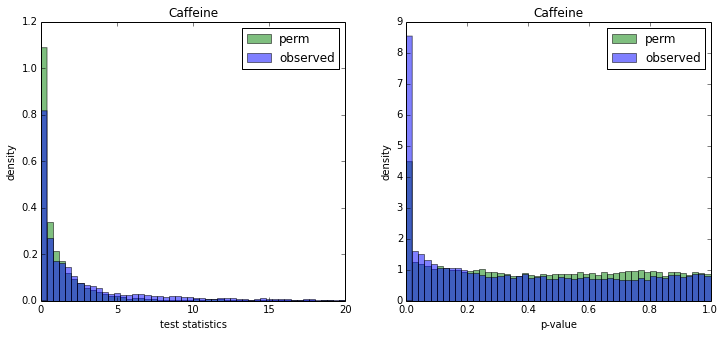

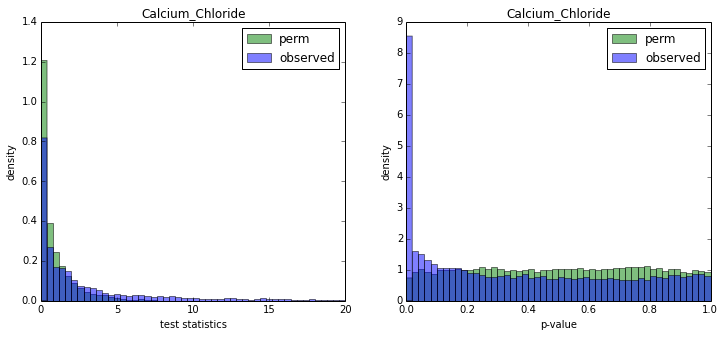

In [19]:
"""
computing test statistics on permuted data
"""
phenotype_vals_perm = phenotype_vals.copy()

for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    perm = np.random.permutation(phenotype_vals[p_ID].values)
    phenotype_vals_perm[p_ID] = perm
  
    #run linear regression on each SNP on permutated and non-permuted data
    lm = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals.values)
    lm_perm = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals_perm.values)
    
    #plot
    fig = pl.figure(figsize=[12,5])
    pl.subplot(1,2,1)
    pl.hist(lm_perm.test_statistics.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,20),label='perm')
    pl.hist(lm.test_statistics[1],normed=True,color='b',alpha=0.5,bins=50,range=(0,20),label='observed')
    pl.xlabel('test statistics')
    pl.ylabel('density')
    pl.title(p_ID)

    pl.legend()
    pl.subplot(1,2,2)
    p=pl.hist(lm_perm.pvalues.flatten(),normed=True,color='g',alpha=0.5,bins=50,range=(0,1),label='perm')
    p=pl.hist(lm.pvalues.flatten(),normed=True,color='b',alpha=0.5,bins=50,range=(0,1),label='observed')
    pl.title(p_ID)
    pl.xlabel('p-value')
    pl.ylabel('density')
    pl.legend()

## False discovery rates

False discovery rates (FDR) give an idea on the expected type-1 error rate at a given P-value threshold. If we are testing millions of hypotheses, then we might be willing to accept type-1 errors at a given rate, if in return we get more discoveries.

This measure gives a useful alternative to traditional Bonferroni correction, which bounds the so-called family-wise error rate (FWER), namely the probability of having at least a single type 1 error.



#### $q$-values

Definition: minimum false discovery rate threshold that would allow the variable to be significant.

In the following we are computing $q$-values for each SNP first on the original data and then on permuted data. By permuting the data we break any dependence between the SNP and the phenotype, making the data come from the null distribution (no association).

(0, 10)

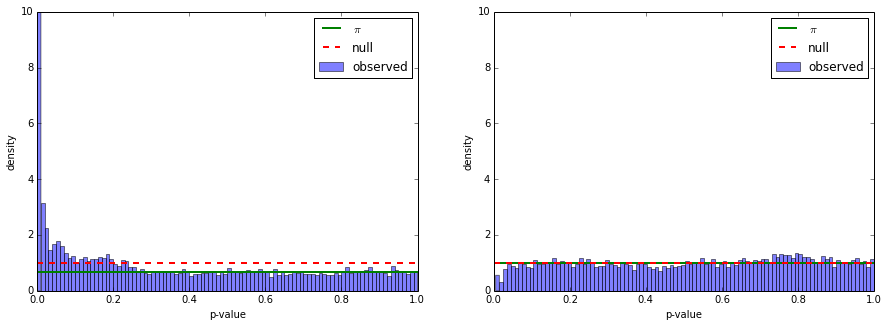

In [20]:
#fitting q-values using the Benjamini-Hochberg step-down procedure

import limix.stats.fdr as fdr
fig = pl.figure(3,figsize=[15,5])

#1. on the real tests
pl.subplot(1,2,1)
qv, pi0 = fdr.qvalues(lm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
fig = pl.figure(3,figsize=[8,5])
pl.hist(lm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))

#2. on permuted p-values
pl.subplot(1,2,2)
qv_perm, pi0 = fdr.qvalues(lm_perm.pvalues[1], return_pi0=True)
#plot distribution of p-values and fitted \pi parameter:
pl.hist(lm_perm.pvalues[1],bins=100,normed=True,color='b',label='observed',alpha=0.5)
pl.axhline(pi0,color='g',linewidth=2,label='$\pi$')
pl.axhline(1,color='r',linestyle='--',linewidth=2,label='null')
pl.legend()
pl.xlabel('p-value')
pl.ylabel('density')
pl.ylim((0,10))



To compare the differences and similarities between multiple hypothesis correctin via the false discovery rate and the family-wise error rate, we plot q-values (estimated by the Benjamini and Hochberg procedure) and the family-wise error rate (upper bounded by the Bonferoni method)

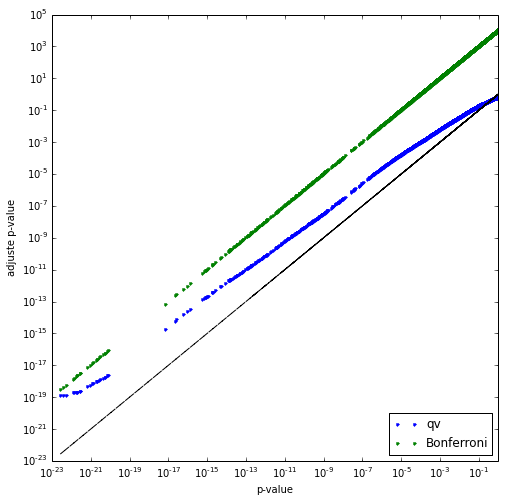

In [21]:
# compare q-values against p-values and Bonferroni adjustement:
pl.figure(figsize=[8,8])
pl.plot((lm.pvalues[1]),(qv),'.',label = 'qv')
pl.plot((lm.pvalues[1]),(lm.pvalues[1]*snps.shape[1]),'.',label = 'Bonferroni')
pl.plot(lm.pvalues[1],lm.pvalues[1],'k--')
pl.yscale("log")
pl.xscale("log")
pl.xlabel('p-value')
pl.ylabel('adjuste p-value')
pl.legend(loc='lower right')




An interesting observation is that for a single significant SNP, the false discovery rate and the family-wise error rate are the same, whereas they start to differ when loweringt the significance threshold.

### Conditional analysis

For the phenotype Cadmium Chloride there was one very large effect visisble. In th efollowing we perform a conditional analysis to find additional secondary associations.

Note that all the phenotypes condition on the same SNP, that has an association to the first phenotype only.

In [22]:
#create a matrix of covariates, one being the SNP to condition on 
#and a constant vector of ones representing the bias term.
imax = lm.pvalues[0].argmin()

covars_conditional=np.concatenate((snps[sample_idx,imax:imax+1],np.ones((phenotype_vals.values.shape[0],1))),1)
                                  

#run linear regression on each SNP
lm_conditional = qtl.test_lm(snps=snps[sample_idx],pheno=phenotype_vals.values,covs=covars_conditional)

#convert P-values to a DataFrame for nice output writing:
pvalues_lm_conditional = pd.DataFrame(data=lm_conditional.pvalues.T,index=dataset.geno_ID,
                       columns=phenotype_ID)

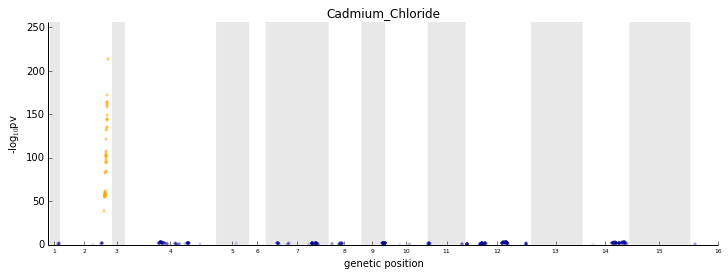

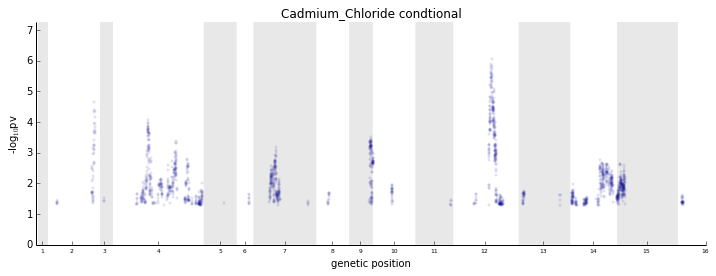

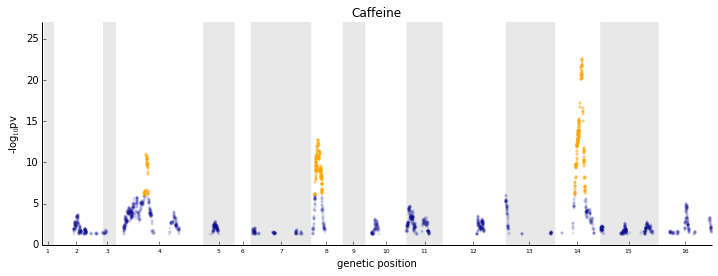

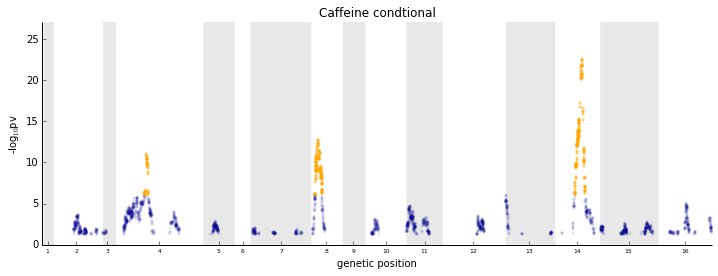

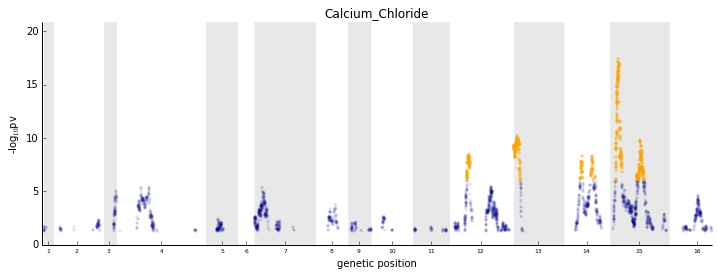

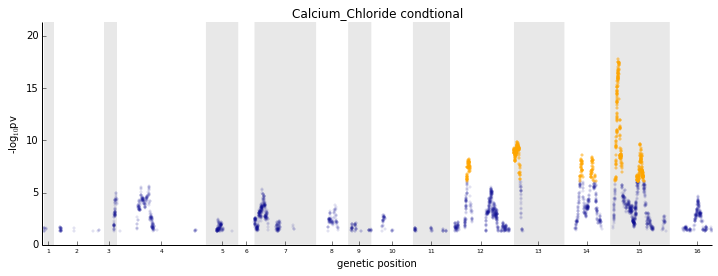

In [23]:
for ip, p_ID in enumerate(dataset.phenotype_ID[0:P_max]):
    pl.figure(figsize=[12,4])
    plot_manhattan(posCum=position['pos_cum'],pv=pvalues_lm[p_ID].values,chromBounds=chromBounds,thr_plotting=0.05)
    pl.title(p_ID)
    pl.figure(figsize=[12,4])
    plot_manhattan(posCum=position['pos_cum'],pv=pvalues_lm_conditional[p_ID].values,chromBounds=chromBounds,thr_plotting=0.05)
    pl.title(p_ID+" condtional")
    

Observation: For all but the associated phenotype the conditional analysis looks almost identical to the original analysis.